<a href="https://colab.research.google.com/github/quinn-dougherty/AB-Demo/blob/master/COLAB_version_of_plt_refactor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import sqlite3 as sl
import pandas as pd  # type: ignore


COLORS_by_TYPE = {
    'fire': 'red',
    'water': '#09E1FF',
    'normal': '#1DFDA8',
    'poison': '#B918FF',
    'electric': 'yellow',
    'ground': '#FF9C15',
    'fairy': '#FF69B4',
    'grass': '#34FF5C',
    'bug': '#90EE38',
    'psychic': '#B71ECF',
    'rock': '#DCB883',
    'fighting': '#FF3A17',
    'ghost': '#6817ff',
    'ice': '#52fffa',
    'dragon': '#a533ff',
    'dark': '#3D009C',
    'flying': '#4da1ff',
    'steel': '#bfbfbf'}


def clean_lite_6(datf: pd.DataFrame) -> pd.DataFrame:
    return (datf.fillna('')
            .assign(Legendary=[1 if x else 0 for x in datf.Legendary],
                    Sp_Attack=datf['Sp. Atk'],
                    Sp_Defense=datf['Sp. Def'],
                    Type1=datf['Type 1'],
                    Type2=datf['Type 2'])
            .drop(['Sp. Atk', 'Sp. Def', 'Type 1', 'Type 2'], axis=1)
            .rename(lambda s: s.lower() + '_g6', axis='columns')
            )


def clean_7(datf: pd.DataFrame) -> pd.DataFrame:
    '''we need to renamed `against_fight` to `against_fighting`'''
    return datf


df6 = pd.read_csv('https://raw.githubusercontent.com/pokepokepokedex/pokedex-ds-quinn/master/Pokemon.csv').pipe(clean_lite_6)

df7 = pd.read_csv('https://raw.githubusercontent.com/pokepokepokedex/pokedex-ds-quinn/master/pokemon_w7.csv').pipe(clean_7)

df = df7.merge(df6, how='outer', left_on='name', right_on='name' + '_g6')






import pandas as pd # type: ignore
import numpy as np # type: ignore
from scipy.stats import norm # type: ignore
import altair as alt # type : ignore
from typing import Optional
from functools import reduce
from itertools import chain
Vcat = lambda R,S: R & S
Ocat = lambda C,D: C + D

#from models import df, COLORS_by_TYPE


types = set(chain.from_iterable(df[['type1', 'type2']].values)) - {np.nan}

ordering = pd.DataFrame(np.ones((len(types), len(types))), columns=types, index=types)



class PokeDescribe: 
    def __init__(self, datf: pd.DataFrame): 
        self.TYPE_COLOR_MAPPING = COLORS_by_TYPE
        self.HEIGHT = 30
        self.WIDTH = 330
        self.xlim = (0, 180)
        self.stats = ['hp', 'attack', 'defense', 
                      'sp_attack', 'sp_defense', 'speed']
        self.df = datf
        self.x = np.linspace(self.xlim[0], self.xlim[1], 1000)
        self.gaussians = {name: norm(loc=self.df[name].mean(), 
                                     scale=self.df[name].std()) 
                          for name in self.stats}
        self.bells = pd.DataFrame({**{'x': self.x}, 
                                   **{name: self.gaussians[name].pdf(self.x) 
                                      for name in self.stats}})
        self.C = alt.Chart(self.bells, 
                           height=self.HEIGHT, 
                           width=self.WIDTH
                          ).mark_line(color='white').encode(
            x=alt.X('x', title=None, axis=alt.Axis(labels=False)))
        self.charts = {name: self.C.encode(y=alt.Y(name, title=None, axis=alt.Axis(labels=False))) for name in self.stats}
        self.BellCurves = reduce(Vcat, [self.charts[name] for name in self.stats])

class PokeDescribeNAME(PokeDescribe): 
    def __init__(self, datf: pd.DataFrame, Name: str): 
        super().__init__(datf)
        self.PSI = 50
        self.pokename = Name
        self.typ = self.df[self.df.name==self.pokename].type1.values[0]
        self.typ_color = self.TYPE_COLOR_MAPPING[self.typ]
        self.y_max = 1.3 * max([max(ls) for ls in [self.gaussians[st].pdf(self.x) for st in self.stats]])
        self.y = pd.DataFrame({'y': np.linspace(0, self.y_max, self.PSI)})
        self.D = alt.Chart(self.y).mark_line(color=self.typ_color).encode(y=alt.Y('y', title=None))
        self.means = {st: self.df[self.df.name==self.pokename][st].mean() for st in self.stats}
        self.Dcharts = {st: self.D.encode(x=alt.value(self.means[st]))
                        for st in self.stats}
        self.SHOW = reduce(Vcat, [self.charts[st] + self.Dcharts[st] 
                                  for st in self.stats]
                          ).configure_text(color='white', angle=90)



# from gaussians import PokeDescribeNAME

# from models import df, COLORS_by_TYPE

from typing import List
import matplotlib.pyplot as plt
import seaborn as sns


raichu = PokeDescribeNAME(df, 'Charizard')

In [0]:
raichu.bells.head()

,attack,defense,hp,sp_attack,sp_defense,speed,x
0,0.000662,0.000777,0.000518,0.001087,0.000570,0.000992,0.000000
1,0.000671,0.000788,0.000527,0.001100,0.000580,0.001006,0.180180
2,0.000680,0.000798,0.000537,0.001114,0.000589,0.001021,0.360360
3,0.000689,0.000810,0.000546,0.001128,0.000599,0.001035,0.540541
4,0.000699,0.000821,0.000556,0.001141,0.000609,0.001050,0.720721


In [0]:
raichu.means

{'attack': 104.0,
 'defense': 78.0,
 'hp': 78.0,
 'sp_attack': 159.0,
 'sp_defense': 115.0,
 'speed': 100.0}

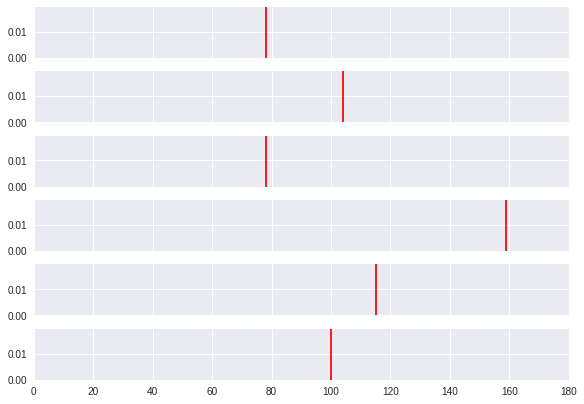

In [0]:
stats = ['hp', 'attack', 'defense', 'sp_attack', 'sp_defense', 'speed']

fig, axes = plt.subplots(nrows=len(stats), ncols=1, sharex=True, constrained_layout=True)
#axes.flatten()


def bell(sts: List[str]): 
    for i in range(len(sts)): 
        c = COLORS_by_TYPE[raichu.typ]
        axes[i].set_xlim(raichu.xlim)
        axes[i].set_ylim(0, raichu.y_max)
        axes[i].axvline(raichu.means[sts[i]], color=c)#, xmin=raichu.xlim[0], xmax=raichu.xlim[1])
        axes[i].plot(x=raichu.bells.x, y=raichu.bells[sts[i]], color=c)


# for i in range(len(stats)): 
#     (i)
bell(stats)

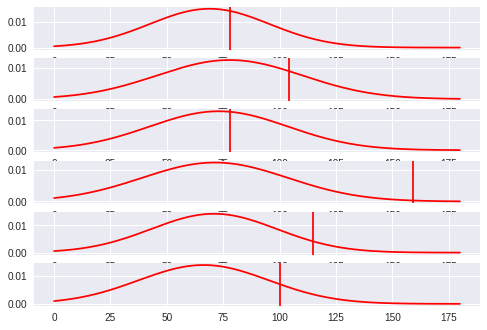

In [0]:
stats = ['hp', 'attack', 'defense', 'sp_attack', 'sp_defense', 'speed']
sts = stats

c = COLORS_by_TYPE[raichu.typ]

plt.figure(1)

plt.subplot(611)
plt.plot(raichu.bells.x, raichu.bells.hp, color=c)
plt.axvline(raichu.means[sts[0]], color=c)

plt.subplot(612)
plt.plot(raichu.bells.x, raichu.bells.attack, color=c)
plt.axvline(raichu.means[sts[1]], color=c)

plt.subplot(613)
plt.plot(raichu.bells.x, raichu.bells.defense, color=c)
plt.axvline(raichu.means[sts[2]], color=c)

plt.subplot(614)
plt.plot(raichu.bells.x, raichu.bells.sp_attack, color=c)
plt.axvline(raichu.means[sts[3]], color=c)

plt.subplot(615)
plt.plot(raichu.bells.x, raichu.bells.sp_defense, color=c)
plt.axvline(raichu.means[sts[4]], color=c)

plt.subplot(616)
plt.plot(raichu.bells.x, raichu.bells.speed, color=c)
plt.axvline(raichu.means[sts[5]], color=c)


plt.show()

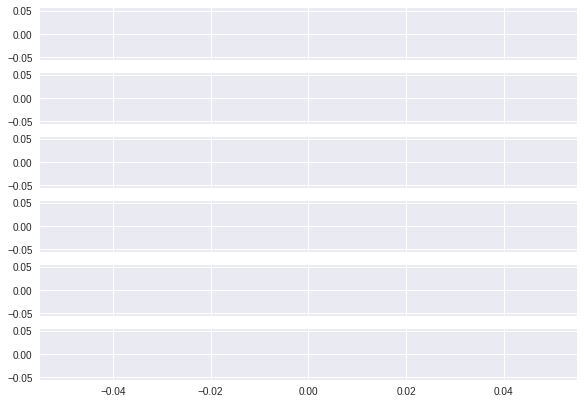

In [0]:
fig, ax = plt.subplots(nrows=6, ncols=1, constrained_layout=True, sharex=True)

# for i in range(6): 
#     ax[i].set_xlim(raichu.xlim)

ax[0].plot(x=raichu.bells.x, y=raichu.bells.hp, color='black')
ax[1].plot(x=raichu.bells.x, y=raichu.bells.attack, color='black')
ax[2].plot(x=raichu.bells.x, y=raichu.bells.defense, color='black')
ax[3].plot(x=raichu.bells.x, y=raichu.bells.sp_attack, color='black')
ax[4].plot(x=raichu.bells.x, y=raichu.bells.sp_defense, color='black')
ax[5].plot(x=raichu.bells.x, y=raichu.bells.speed, color='black')


plt.show()

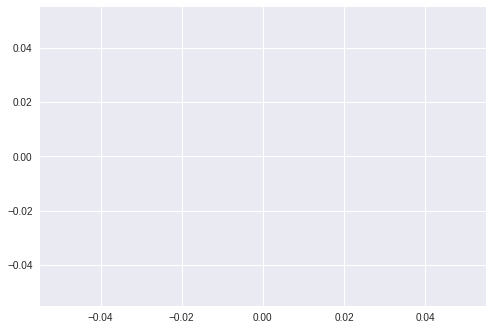

In [0]:
plt.plot(x=raichu.bells.x, y=raichu.bells.defense, color='black'); 

In [0]:
import seaborn as sns

sns.line(x=raichu.bells.x, y=raichu.bells.defense, color=COLORS_by_TYPE[raichu.typ])
sns.line(x=raichu.bells.x, y=raichu.bells.sp_attack, color=COLORS_by_TYPE[raichu.typ])

AttributeError: ignored

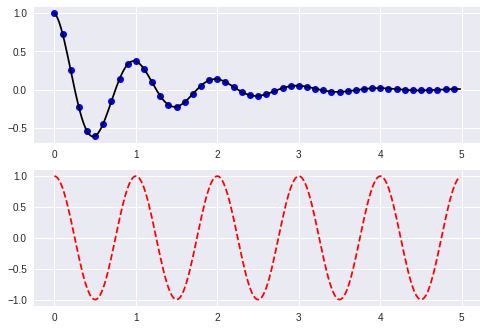

In [0]:
import numpy as np
import matplotlib.pyplot as plt

def f(t):
    return np.exp(-t) * np.cos(2*np.pi*t)

t1 = np.arange(0.0, 5.0, 0.1)
t2 = np.arange(0.0, 5.0, 0.02)

plt.figure(1)
plt.subplot(211)
plt.plot(t1, f(t1), 'bo', t2, f(t2), 'k')

plt.subplot(212)
plt.plot(t2, np.cos(2*np.pi*t2), 'r--')
plt.show()

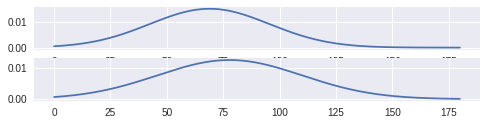

In [0]:
plt.figure(1)
plt.subplot(611)
plt.plot(raichu.bells.x, raichu.bells.hp)
plt.subplot(612)
plt.plot(raichu.bells.x, raichu.bells.attack)

plt.show()